<a href="https://colab.research.google.com/github/laribar/SmartAITraderBot/blob/main/Bot_Funcional_v4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [70]:
!pip install ta
!pip install yfinance
!pip install xgboost
!pip install python-binance


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.3/130.3 kB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.7/295.7 kB 21.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 58.1 MB/s eta 0:00:00


In [ ]:
# ====================================================
# 1. IMPORTAÇÕES
# ====================================================
import yfinance as yf
import numpy as np
import pandas as pd
import ta
import requests
import time  # Para usar time.sleep()
import matplotlib.pyplot as plt
from datetime import datetime
from datetime import timedelta
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from xgboost import XGBClassifier
XGBClassifier(
    n_estimators=200,
    max_depth=4,                 # menor profundidade = menos overfitting
    subsample=0.8,               # usa 80% dos dados por árvore
    colsample_bytree=0.8,        # usa 80% das features por árvore
    learning_rate=0.05,          # suaviza o aprendizado
    early_stopping_rounds=10,    # para de treinar se não melhorar
    eval_metric="mlogloss",
    use_label_encoder=False,
    random_state=42
)

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
# ====================================================
# BLOCO 1 - CONFIGURAÇÃO DE PASTAS E IMPORTS EXTRA
# ====================================================
import os
import joblib
from tensorflow.keras.models import load_model

# Criar pasta onde os modelos serão salvos
os.makedirs("/content/models", exist_ok=True)
# ====================================================
# BLOCO 2 - SALVAR E CARREGAR MODELOS TREINADOS
# ====================================================
def get_model_path(asset, interval, model_type="xgb"):
    asset_clean = asset.replace("-", "")
    ext = "joblib" if model_type == "xgb" else "h5"
    return f"/content/models/{model_type}_model_{asset_clean}_{interval}.{ext}"

# --- XGBoost ---
def save_xgb_model(model, asset, interval):
    path = get_model_path(asset, interval, model_type="xgb")
    joblib.dump(model, path)
    print(f"💾 Modelo XGBoost salvo em: {path}")

def load_xgb_model(asset, interval):
    path = get_model_path(asset, interval, model_type="xgb")
    if os.path.exists(path):
        print(f"📂 Modelo XGBoost carregado de: {path}")
        return joblib.load(path)
    return None

# --- LSTM ---
def save_lstm_model(model, asset, interval):
    path = get_model_path(asset, interval, model_type="lstm")
    model.save(path)
    print(f"💾 Modelo LSTM salvo em: {path}")

def load_lstm_model(asset, interval, data=None, window_size=20):
    from tensorflow.keras.models import load_model

    path = get_model_path(asset, interval, model_type="lstm")
    if os.path.exists(path):
        print(f"📂 Modelo LSTM encontrado em: {path}")
        try:
            model = load_model(path)
            print(f"✅ Modelo LSTM carregado com sucesso para {asset} ({interval})")
        except Exception as e:
            print(f"❌ Falha ao carregar modelo LSTM: {e}")
            return None

        model.window_size = window_size

        if data is not None:
            try:
                _, _, scaler = prepare_lstm_data(data, window_size=window_size)
                model.scaler = scaler
            except Exception as e:
                print(f"⚠️ Erro ao aplicar scaler ao LSTM carregado: {e}")
                model.scaler = None
        else:
            print("⚠️ Atenção: LSTM carregado sem dados para gerar o scaler!")
            model.scaler = None

        return model
    else:
        print(f"🚫 Modelo LSTM NÃO encontrado em: {path}")
        return None





# ====================================================
# 2. CONFIGURAÇÕES
# ====================================================
ASSETS = ["BTC-USD"] #, "ETH-USD", "BNB-USD", "SOL-USD", "XRP-USD", "AVAX-USD", "AAVE-USD", "DOT-USD", "NEAR-USD", "ADA-USD"


TIMEFRAMES = [
    {"interval": "15m", "period": "30d", "atr": 0.02},
    {"interval": "1h", "period": "90d", "atr": 0.03},
    {"interval": "1d", "period": "1000d", "atr": 0.05}
]

TELEGRAM_TOKEN = "8044593190:AAFtUWYHd3uqd-AtQi3uqg42F9G6uV95v8k"
TELEGRAM_CHAT_ID = "-4744645054"

# ====================================================
# 3. COLETA DE DADOS
# ====================================================
def get_stock_data(asset, interval="15m", period="700d"):
    data = yf.download(asset, period=period, interval=interval, progress=False, auto_adjust=False)
    if isinstance(data.columns, pd.MultiIndex):
        data.columns = data.columns.get_level_values(0)
    data.columns = [col.split()[-1] if " " in col else col for col in data.columns]
    data = data.loc[:, ~data.columns.duplicated()]
    col_map = {col: std_col for col in data.columns for std_col in ["Open", "High", "Low", "Close", "Adj Close", "Volume"] if std_col.lower() in col.lower()}
    data = data.rename(columns=col_map)
    data = data[["Open", "High", "Low", "Close", "Volume"]]
    if not all(col in data.columns for col in ["Open", "High", "Low", "Close", "Volume"]):
        raise ValueError(f"⚠️ Dados de {asset} não possuem todas as colunas necessárias.")
    return data


# ====================================================
# 4. INDICADORES TÉCNICOS
# ====================================================
def calculate_indicators(data):
    data = data.copy().reset_index(drop=True)
    for col in ["Open", "High", "Low", "Close", "Volume"]:
        data[col] = data[col].astype(float)

    # Indicadores Clássicos
    data["RSI"] = ta.momentum.RSIIndicator(close=data["Close"], window=14).rsi()
    data["SMA_50"] = ta.trend.SMAIndicator(close=data["Close"], window=50).sma_indicator()
    data["SMA_200"] = ta.trend.SMAIndicator(close=data["Close"], window=200).sma_indicator()

    macd = ta.trend.MACD(close=data["Close"])
    data["MACD"] = macd.macd()
    data["MACD_Signal"] = macd.macd_signal()

    bb = ta.volatility.BollingerBands(close=data["Close"], window=20)
    data["Bollinger_Upper"] = bb.bollinger_hband()
    data["Bollinger_Lower"] = bb.bollinger_lband()

    adx = ta.trend.ADXIndicator(high=data["High"], low=data["Low"], close=data["Close"], window=14)
    data["ADX"] = adx.adx()

    stoch = ta.momentum.StochasticOscillator(high=data["High"], low=data["Low"], close=data["Close"], window=14)
    data["Stoch_K"] = stoch.stoch()
    data["Stoch_D"] = stoch.stoch_signal()

    # Indicadores adicionais
    data["ATR"] = ta.volatility.AverageTrueRange(high=data["High"], low=data["Low"], close=data["Close"]).average_true_range()
    data["ROC"] = ta.momentum.ROCIndicator(close=data["Close"], window=12).roc()
    data["OBV"] = ta.volume.OnBalanceVolumeIndicator(close=data["Close"], volume=data["Volume"]).on_balance_volume()
    data["CCI"] = ta.trend.CCIIndicator(high=data["High"], low=data["Low"], close=data["Close"], window=20).cci()

    ichimoku = ta.trend.IchimokuIndicator(high=data["High"], low=data["Low"], window1=9, window2=26)
    data["Tenkan_Sen"] = ichimoku.ichimoku_conversion_line()
    data["Kijun_Sen"] = ichimoku.ichimoku_base_line()

    # VWAP e Candles
    data["TP"] = (data["High"] + data["Low"] + data["Close"]) / 3
    data["VWAP"] = (data["TP"] * data["Volume"]).cumsum() / (data["Volume"].replace(0, np.nan).cumsum())
    data.drop("TP", axis=1, inplace=True)

    data["Doji"] = ((abs(data["Close"] - data["Open"]) / (data["High"] - data["Low"] + 1e-9)) < 0.1).astype(int)
    data["Engulfing"] = ((data["Open"].shift(1) > data["Close"].shift(1)) & (data["Open"] < data["Close"]) &
                         (data["Close"] > data["Open"].shift(1)) & (data["Open"] < data["Close"].shift(1))).astype(int)
    data["Hammer"] = (((data["High"] - data["Low"]) > 3 * abs(data["Open"] - data["Close"])) &
                      ((data["Close"] - data["Low"]) / (data["High"] - data["Low"] + 1e-9) > 0.6) &
                      ((data["Open"] - data["Low"]) / (data["High"] - data["Low"] + 1e-9) > 0.6)).astype(int)

    data.dropna(inplace=True)
    return data



# ====================================================
# 4. MODELOS DE MACHINE LEARNING (XGBoost + LSTM)
# ====================================================

def get_feature_columns():
    return [
        "RSI", "MACD", "MACD_Signal", "SMA_50", "SMA_200", "Bollinger_Upper",
        "Bollinger_Lower", "ADX", "Stoch_K", "Stoch_D", "ATR", "ROC", "OBV", "CCI",
        "Tenkan_Sen", "Kijun_Sen", "VWAP", "Doji", "Engulfing", "Hammer", "LSTM_PRED"
    ]


def prepare_lstm_data(data, feature_col="Close", window_size=20):
    df = data.copy().reset_index(drop=True)
    values = df[feature_col].values.reshape(-1, 1)
    scaler = MinMaxScaler()
    scaled = scaler.fit_transform(values)

    X, y = [], []
    for i in range(window_size, len(scaled)):
        X.append(scaled[i - window_size:i, 0])
        y.append(scaled[i, 0])

    X, y = np.array(X), np.array(y)
    X = np.reshape(X, (X.shape[0], X.shape[1], 1))
    return X, y, scaler

def train_lstm_model(data, asset=None, interval=None, window_size=20, verbose=False, force_retrain=False):
    if asset and interval and not force_retrain:
        model = load_lstm_model(asset, interval, data=data, window_size=window_size)
        if model is not None:
            print(f"✅ LSTM carregado para {asset} ({interval})")
            return model  # ⚠️ Modelo já salvo, não treina novamente

    if len(data) < window_size + 20:
        print(f"⚠️ Dados insuficientes para treinar LSTM em {asset} ({interval})")
        return None

    print(f"🚀 Treinando LSTM para {asset} ({interval})...")

    X, y, scaler = prepare_lstm_data(data, window_size=window_size)

    model = Sequential()
    model.add(LSTM(units=50, return_sequences=True, input_shape=(X.shape[1], 1)))
    model.add(Dropout(0.2))
    model.add(LSTM(units=50))
    model.add(Dropout(0.2))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    model.fit(X, y, epochs=10, batch_size=32, verbose=0 if not verbose else 1)

    model.scaler = scaler
    model.window_size = window_size

    if asset and interval:
        save_lstm_model(model, asset, interval)

    return model




def predict_with_lstm(model, data, use_dynamic_calibration=True):
    df = data.copy().reset_index(drop=True)
    values = df["Close"].values.reshape(-1, 1)

    if not hasattr(model, "scaler") or model.scaler is None:
        raise ValueError("❌ LSTM carregado sem scaler.")

    scaled = model.scaler.transform(values)
    last_sequence = scaled[-model.window_size:]
    X_pred = np.reshape(last_sequence, (1, model.window_size, 1))
    predicted_scaled = model.predict(X_pred)[0][0]
    predicted_price = model.scaler.inverse_transform([[predicted_scaled]])[0][0]

    # 🔁 Ajuste dinâmico com base no histórico (se ativado)
    if use_dynamic_calibration:
        try:
            df_log = pd.read_csv("/content/prediction_log.csv")
            df_log = df_log.dropna(subset=["TargetPrice", "Price"])
            df_log["Erro"] = df_log["Price"] - df_log["TargetPrice"]
            if len(df_log) >= 10:  # só aplica se tiver histórico suficiente
                calibration_factor = 1 - (df_log["Erro"].mean() / df_log["TargetPrice"].mean())
                predicted_price *= calibration_factor
                print(f"🔧 Calibração dinâmica aplicada: fator {calibration_factor:.5f}")
        except Exception as e:
            print(f"⚠️ Erro ao aplicar calibração dinâmica: {e}")

    return round(predicted_price, 2)




def train_ml_model(data, asset=None, interval=None, verbose=False):
    # ✅ Verifica se modelo já existe
    if asset and interval:
        existing_model = load_xgb_model(asset, interval)
        if existing_model is not None:
            print(f"✅ Modelo XGBoost já existente para {asset} ({interval}), carregado.")
            return existing_model

    if len(data) < 100:
        return None

    df = data.copy()

    # ✅ Tenta carregar LSTM salvo (sem forçar re-treino)
    try:
        lstm_model = train_lstm_model(data, asset=asset, interval=interval, force_retrain=False)
        lstm_preds = []
        for i in range(len(df)):
            sub_df = df.iloc[:i+1]
            if len(sub_df) < 20:
                lstm_preds.append(np.nan)
            else:
                pred = predict_with_lstm(lstm_model, sub_df)
                lstm_preds.append(pred)
        df["LSTM_PRED"] = lstm_preds
    except Exception as e:
        print(f"⚠️ Erro ao gerar LSTM_PRED: {e}")
        df["LSTM_PRED"] = np.nan

    # Geração do alvo
    df["Future_Close"] = df["Close"].shift(-5)
    df["Future_Return"] = df["Future_Close"] / df["Close"] - 1
    df = df[(df["Future_Return"] > 0.015) | (df["Future_Return"] < -0.015)].copy()
    df["Signal"] = np.where(df["Future_Return"] > 0.015, 1, 0)

    features = get_feature_columns()
    df.dropna(inplace=True)
    X = df[features]
    y = df["Signal"]

    if len(np.unique(y)) < 2:
        return None

    # ✅ Validação com TimeSeriesSplit (primeira divisão)
    from sklearn.model_selection import TimeSeriesSplit
    tscv = TimeSeriesSplit(n_splits=5)
    for train_index, val_index in tscv.split(X):
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]
        break

    if len(np.unique(y_train)) < 2:
        return None

    # Ajuste de peso de classe (para desbalanceamento)
    scale_pos_weight = len(y_train[y_train == 0]) / max(1, len(y_train[y_train == 1]))

    model = XGBClassifier(
        n_estimators=200,
        max_depth=6,
        learning_rate=0.1,
        use_label_encoder=False,
        eval_metric="logloss",
        scale_pos_weight=scale_pos_weight,
        random_state=42
    )
    model.fit(X_train, y_train)

    y_pred = model.predict(X_val)
    report = classification_report(y_val, y_pred, output_dict=True, zero_division=0)

    model.validation_score = {
        "accuracy": report.get("accuracy"),
        "precision": report.get("1", {}).get("precision"),
        "recall": report.get("1", {}).get("recall"),
        "f1": report.get("1", {}).get("f1-score")
    }

    if asset and interval:
        save_xgb_model(model, asset, interval)

    return model


def plot_feature_importance(model, feature_names, top_n=15):
    import matplotlib.pyplot as plt
    importances = model.feature_importances_
    indices = np.argsort(importances)[-top_n:]  # top_n mais importantes

    plt.figure(figsize=(10, 5))
    plt.barh(range(len(indices)), importances[indices], align='center')
    plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
    plt.xlabel("Importância")
    plt.title("🎯 Importância das Features - XGBoost")
    plt.tight_layout()
    plt.grid(True)
    plt.show()



# ====================================================
# 5. UTILITÁRIOS
# ====================================================

def generate_explanation(row, prediction):
    explanation = []
    if prediction == 1:
        explanation.append("🟢 O modelo prevê uma tendência de ALTA.")
    elif prediction == 0:
        explanation.append("🔴 O modelo prevê uma tendência de BAIXA.")
    else:
        explanation.append("⚪ Sinal neutro.")

    if row["RSI"] < 30:
        explanation.append("🔽 RSI abaixo de 30 indica sobrevenda.")
    elif row["RSI"] > 70:
        explanation.append("🔼 RSI acima de 70 indica sobrecompra.")

    if row["SMA_50"] > row["SMA_200"]:
        explanation.append("📈 SMA 50 acima da 200, tendência de alta.")
    else:
        explanation.append("📉 SMA 50 abaixo da 200, tendência de baixa.")

    if row["MACD"] > row["MACD_Signal"]:
        explanation.append("💹 MACD cruzando para cima, possível reversão positiva.")
    else:
        explanation.append("🔻 MACD abaixo da linha de sinal.")

    if row["Doji"] == 1:
        explanation.append("⚠️ Padrão de candle Doji detectado (possível reversão).")

    if row["Engulfing"] == 1:
        explanation.append("📊 Padrão de engolfo detectado (sinal forte de reversão).")

    return "\n".join(explanation)

def calculate_targets(current_price, direction, atr=0.02):
    if direction == 1:
        return {
            "TP1": round(current_price * (1 + atr * 0.5), 2),
            "TP2": round(current_price * (1 + atr * 1.0), 2),
            "SL": round(current_price * (1 - atr * 0.5), 2)
        }
    elif direction == 0:
        return {
            "TP1": round(current_price * (1 - atr * 0.5), 2),
            "TP2": round(current_price * (1 - atr * 1.0), 2),
            "SL": round(current_price * (1 + atr * 0.5), 2)
        }
    else:
        return {"TP1": None, "TP2": None, "SL": None}

def send_telegram_message(message):
    url = f"https://api.telegram.org/bot{TELEGRAM_TOKEN}/sendMessage"
    payload = {"chat_id": TELEGRAM_CHAT_ID, "text": message, "parse_mode": "HTML"}
    response = requests.post(url, json=payload)

    if response.status_code == 200:
        print("📨 Mensagem enviada com sucesso!")
    else:
        print(f"❌ Erro ao enviar mensagem: {response.status_code} - {response.text}")

def predict_next_closes(data, n_steps=5):
    df = data.copy().reset_index(drop=True)
    features = get_feature_columns()
    df.dropna(inplace=True)

    X = df[features]
    y = df["Close"].shift(-1).dropna()
    X = X.loc[y.index]

    if len(X) < 100:
        return [None] * n_steps

    model = RandomForestRegressor(n_estimators=200, max_depth=8, random_state=42)
    model.fit(X, y)

    last_row = df[features].iloc[-1].copy()
    preds = []

    for step in range(n_steps):
        X_input = pd.DataFrame([last_row], columns=features)
        next_close = model.predict(X_input)[0]
        preds.append(round(next_close, 2))

        # Simula avanço do mercado
        last_row["Close"] = next_close
        if "SMA_50" in last_row:
            last_row["SMA_50"] = last_row["SMA_50"] * 0.9 + next_close * 0.1
        if "SMA_200" in last_row:
            last_row["SMA_200"] = last_row["SMA_200"] * 0.95 + next_close * 0.05
        if "VWAP" in last_row:
            last_row["VWAP"] = last_row["VWAP"] * 0.95 + next_close * 0.05
        if "RSI" in last_row:
            last_row["RSI"] = min(100, max(0, last_row["RSI"] + np.random.normal(0, 0.5)))
        if "MACD" in last_row:
            last_row["MACD"] += np.random.normal(0, 0.3)
        if "MACD_Signal" in last_row:
            last_row["MACD_Signal"] += np.random.normal(0, 0.2)

        last_row = last_row[features]

    return preds


def evaluate_past_predictions(results_file="/content/prediction_log.csv", lookahead_candles=5):
    import os
    import pandas as pd
    import yfinance as yf
    import matplotlib.pyplot as plt
    from datetime import timedelta

    if not os.path.exists(results_file):
        print("📭 Nenhum log de previsão encontrado.")
        return

    df = pd.read_csv(results_file)
    df["Date"] = pd.to_datetime(df["Date"])

    print(f"📊 Avaliando {len(df)} previsões salvas...")

    evaluation = []

    for idx, row in df.iterrows():
        asset = row["Asset"]
        interval = row["Timeframe"]
        prediction_time = row["Date"]
        predicted_signal = row["Signal"]
        predicted_target = row.get("TargetPrice", None)

        try:
            candles = yf.download(asset, start=prediction_time, interval=interval, progress=False)
            candles = candles[candles.index > prediction_time]

            if candles.empty or len(candles) < lookahead_candles:
                continue

            candles = candles.head(lookahead_candles)
            final_close = candles["Close"].iloc[-1]

            if predicted_signal == 1:
                result = "Acertou" if final_close >= predicted_target else "Errou"
            elif predicted_signal == 0:
                result = "Acertou" if final_close <= predicted_target else "Errou"
            else:
                result = "Neutro"

            if predicted_target:
                perc_change = ((final_close - predicted_target) / predicted_target) * 100
                abs_error = final_close - predicted_target
            else:
                perc_change = None
                abs_error = None

            acertou = 1 if result == "Acertou" else 0

            evaluation.append({
                "Ativo": asset,
                "Timeframe": interval,
                "Data Previsão": prediction_time.strftime("%Y-%m-%d %H:%M"),
                "Sinal Previsto": "Compra" if predicted_signal == 1 else "Venda" if predicted_signal == 0 else "Neutro",
                "Valor Projetado (LSTM)": round(predicted_target, 2) if predicted_target else None,
                "Resultado": result,
                "Valor Real": round(final_close, 2),
                "Variação Real": f"{perc_change:+.2f}%" if perc_change is not None else "N/A",
                "Erro Absoluto": f"{abs_error:+.2f}" if abs_error is not None else "N/A",
                "Acertou": acertou
            })

        except Exception as e:
            print(f"⚠️ Erro ao avaliar {asset} em {prediction_time}: {e}")
            continue

    df_eval = pd.DataFrame(evaluation)

    # 📊 Resumo de acertos e erros
    resumo = df_eval.groupby(["Ativo", "Timeframe", "Resultado"]).size().unstack(fill_value=0)
    resumo["Total"] = resumo.sum(axis=1)
    resumo["Acurácia (%)"] = (resumo.get("Acertou", 0) / resumo["Total"] * 100).round(2)
    display(resumo)

    # 📈 Gráfico de barras
    resumo_plot = resumo[["Acertou", "Errou"]] if "Errou" in resumo.columns else resumo[["Acertou"]]
    resumo_plot.plot(kind="bar", figsize=(10, 5), title="📊 Acertos vs Erros por Ativo e Timeframe")
    plt.ylabel("Quantidade de Sinais")
    plt.xticks(rotation=45)
    plt.grid(axis="y")
    plt.tight_layout()
    plt.show()

    # 📄 Tabela completa das previsões
    display(df_eval)

    # 🔄 Atualizar o prediction_log.csv com a coluna 'Acertou'
    try:
        df_log = pd.read_csv(results_file)
        df_log["Date"] = pd.to_datetime(df_log["Date"])

        for _, row in df_eval.iterrows():
            dt = pd.to_datetime(row["Data Previsão"])
            mask = (df_log["Date"] == dt) & (df_log["Asset"] == row["Ativo"]) & (df_log["Timeframe"] == row["Timeframe"])
            df_log.loc[mask, "Acertou"] = row["Acertou"]

        df_log.to_csv(results_file, index=False)
        print("✅ Log de previsões atualizado com coluna 'Acertou'.")

    except Exception as e:
        print(f"❌ Erro ao atualizar o prediction_log.csv com 'Acertou': {e}")

    return df_eval



def clear_models(model_dir="/content/models"):
    import shutil

    if os.path.exists(model_dir):
        print(f"🧹 Limpando todos os modelos salvos em: {model_dir}")
        shutil.rmtree(model_dir)
        os.makedirs(model_dir, exist_ok=True)
        print("✅ Modelos deletados com sucesso.")
    else:
        print("📂 Nenhuma pasta de modelos encontrada para limpar.")


def plot_prediction_performance(log_path="/content/prediction_log.csv"):
    import pandas as pd
    import matplotlib.pyplot as plt
    from datetime import timedelta
    import os

    if not os.path.exists(log_path):
        print("📭 Nenhum log encontrado.")
        return

    df = pd.read_csv(log_path)
    df["Date"] = pd.to_datetime(df["Date"])

    # Apenas linhas com TargetPrice válido
    df = df.dropna(subset=["TargetPrice"])
    df["Erro"] = df["Price"] - df["TargetPrice"]
    df["AbsError"] = abs(df["Erro"])
    df["Dia"] = df["Date"].dt.date

    print(f"📊 Total de previsões com valor previsto: {len(df)}")

    # 🔹 Erro absoluto médio por dia
    df_grouped = df.groupby("Dia")["AbsError"].mean()

    plt.figure(figsize=(8, 4))
    plt.plot(df_grouped.index, df_grouped.values, marker="o")
    plt.title("📈 Erro Absoluto Médio por Dia")
    plt.xlabel("Data")
    plt.ylabel("Erro ($)")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # 🔹 Dispersão do valor previsto x real
    plt.figure(figsize=(8, 4))
    plt.scatter(df["TargetPrice"], df["Price"], alpha=0.6)
    plt.plot([df["TargetPrice"].min(), df["TargetPrice"].max()],
             [df["TargetPrice"].min(), df["TargetPrice"].max()], 'r--', label="Perfeito")
    plt.title("🎯 Valor Previsto (LSTM) vs Real")
    plt.xlabel("Valor Previsto")
    plt.ylabel("Valor Real")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # 🔹 Distribuição de erro
    plt.figure(figsize=(8, 4))
    df["Erro"].hist(bins=30)
    plt.title("📊 Distribuição dos Erros")
    plt.xlabel("Erro (Preço Real - Previsto)")
    plt.ylabel("Frequência")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def enviar_grafico_lucro_por_confianca(log_path="/content/prediction_log.csv"):
    import matplotlib.pyplot as plt

    if not os.path.exists(log_path):
        print("📭 Nenhum log encontrado.")
        return

    df = pd.read_csv(log_path)
    if "AdjustedProb" not in df.columns or "TP1" not in df.columns or "Price" not in df.columns:
        print("⚠️ Colunas necessárias não encontradas no log.")
        return

    df = df.dropna(subset=["AdjustedProb", "TP1", "Price"])
    df["LucroEstimado"] = df["TP1"] - df["Price"]
    df["FaixaConfiança"] = pd.cut(df["AdjustedProb"], bins=[0, 0.6, 0.7, 0.8, 0.9, 1.0], labels=["≤60%", "60-70%", "70-80%", "80-90%", ">90%"])

    lucro_medio = df.groupby("FaixaConfiança")["LucroEstimado"].mean()

    plt.figure(figsize=(8, 4))
    lucro_medio.plot(kind="bar", color="skyblue")
    plt.title("📊 Lucro Estimado Médio por Faixa de Confiança")
    plt.ylabel("Lucro Estimado ($)")
    plt.xlabel("Faixa de Confiança Ajustada")
    plt.grid(True)
    plt.tight_layout()

    path = "/tmp/lucro_por_confianca.png"
    plt.savefig(path)
    plt.close()

    with open(path, "rb") as img:
        url = f"https://api.telegram.org/bot{TELEGRAM_TOKEN}/sendPhoto"
        files = {"photo": img}
        data = {
            "chat_id": TELEGRAM_CHAT_ID,
            "caption": "📊 Lucro médio estimado por faixa de confiança ajustada"
        }
        response = requests.post(url, data=data, files=files)
        if response.status_code == 200:
            print("✅ Gráfico de lucro por confiança enviado.")
        else:
            print(f"❌ Falha ao enviar gráfico: {response.status_code} - {response.text}")

def adjust_signal_based_on_history(asset, timeframe, max_lookback=20, min_signals=5):
    try:
        df = pd.read_csv("prediction_log.csv")
        df["Date"] = pd.to_datetime(df["Date"])
        df = df[(df["Asset"] == asset) & (df["Timeframe"] == timeframe)]

        if len(df) < min_signals or "Acertou" not in df.columns:
            return 1.0  # Sem histórico confiável, mantém 100% do sinal original

        recent = df.sort_values("Date", ascending=False).head(max_lookback)
        acuracia = recent["Acertou"].mean()
        return acuracia  # Ex: 0.6 = 60% de confiança histórica recente

    except Exception as e:
        print(f"⚠️ Erro ao ajustar com histórico: {e}")
        return 1.0


def enviar_grafico_carteira():
    image_path = "/tmp/evolucao_carteira.png"
    if os.path.exists(image_path):
        with open(image_path, "rb") as img:
            url = f"https://api.telegram.org/bot{TELEGRAM_TOKEN}/sendPhoto"
            files = {"photo": img}
            data = {
                "chat_id": TELEGRAM_CHAT_ID,
                "caption": "💼 Evolução da carteira virtual com base nos sinais do bot"
            }
            response = requests.post(url, data=data, files=files)
            if response.status_code == 200:
                print("✅ Gráfico da carteira enviado ao Telegram.")
            else:
                print(f"❌ Erro ao enviar imagem: {response.status_code} - {response.text}")



# ====================================================
# 5.1 CARTEIRA VIRTUAL PARA SIMULAÇÃO
# ====================================================
# ====================================================
# 5.1 CARTEIRA VIRTUAL PARA SIMULAÇÃO
# ====================================================

carteira_virtual = {
    "capital_inicial": 10000.0,
    "capital_atual": 10000.0,
    "em_operacao": False,
    "ativo": None,
    "entrada": 0.0,
    "quantidade": 0.0,
    "tipo": None,
    "data_entrada": None
}

def simular_trade(row, lookahead_candles=5, taxa=0.001, slippage=0.002):
    import yfinance as yf

    print("\n🚨 Entrando na função simular_trade()")
    print(f"🔍 Linha completa:\n{row}\n")

    if not isinstance(row, pd.Series):
        print("⚠️ Linha recebida não é Series, foi:", type(row))
        return None

    if pd.isna(row["Date"]):
        print("⚠️ Entrada ignorada por data inválida:", row["Date"])
        return None

    try:
        data_entrada = pd.to_datetime(row["Date"])
        if data_entrada.tzinfo is not None:
            data_entrada = data_entrada.tz_localize(None)
    except Exception as e:
        print(f"❌ Erro ao converter data: {e}")
        return None

    asset = row["Asset"]
    interval = row["Timeframe"]

    try:
        # Conversão segura usando to_scalar universal
        entrada = to_scalar(row["Price"])
        tp1 = to_scalar(row["TP1"])
        sl = to_scalar(row["SL"])
        signal = int(to_scalar(row["Signal"]))
    except Exception as e:
        print(f"❌ Erro ao converter valores numéricos: {e}")
        return None

    print(f"📌 entrada: {entrada} ({type(entrada)})")
    print(f"📌 TP1: {tp1} ({type(tp1)})")
    print(f"📌 SL: {sl} ({type(sl)})")
    print(f"📌 Signal: {signal} ({type(signal)})")

    try:
        df_future = yf.download(asset, interval=interval, start=data_entrada, progress=False)

        df_future.index = pd.to_datetime(df_future.index)
        if df_future.index.tz is not None:
            df_future.index = df_future.index.tz_localize(None)

        df_future = df_future[df_future.index > data_entrada].head(lookahead_candles)

        # 🔧 Garantir colunas limpas
        df_future = df_future.copy()
        df_future = df_future.loc[:, ~df_future.columns.duplicated()]
        df_future.columns = [str(col) for col in df_future.columns]

        if df_future.empty:
            print(f"⚠️ Sem candles futuros para {asset} em {interval}")
            return None

        saida = None
        resultado = "Indefinido"
        def to_scalar(val):
            try:
                if isinstance(val, pd.Series):
                    return float(val.iloc[0])
                elif isinstance(val, (np.ndarray, list)):
                    return float(val[0])
                else:
                    return float(val)
            except Exception as e:
                print(f"❌ Falha ao converter valor escalar: {val} | erro: {e}")
            return np.nan
        for _, candle in df_future.iterrows():
            try:
                preco_max = to_scalar(candle.get("High"))
                preco_min = to_scalar(candle.get("Low"))
            except Exception as e:
                print(f"❌ Erro ao extrair preços: {e}\nHigh={candle['High']} | Low={candle['Low']}")
                continue

            print(f"🧪 Comparando: preco_max={preco_max}, preco_min={preco_min}, tp1={tp1}, sl={sl}")

            if any(pd.isna(x) for x in [preco_max, preco_min, tp1, sl]):
                print("⚠️ Valores nulos detectados — ignorando candle.")
                continue
            print(f"🔍 Tipos: High={type(preco_max)}, Low={type(preco_min)}, valores: {preco_max}, {preco_min}")

            if signal == 1:
                if preco_max >= tp1:
                    saida = tp1
                    resultado = "TP1"
                    break
                elif preco_min <= sl:
                    saida = sl
                    resultado = "SL"
                    break
            elif signal == 0:
                if preco_min <= tp1:
                    saida = tp1
                    resultado = "TP1"
                    break
                elif preco_max >= sl:
                    saida = sl
                    resultado = "SL"
                    break

        if saida is None:
            saida = df_future["Close"].iloc[-1]
            resultado = "Sem alvo"

        entrada_real = entrada * (1 + taxa + slippage)
        saida_real = saida * (1 - taxa - slippage)
        quantidade = carteira_virtual["capital_atual"] / entrada_real

        if any(pd.isna(x) for x in [saida_real, entrada_real, quantidade]):
            print("⚠️ Valores inválidos detectados — trade ignorado.")
            return None

        lucro = (saida_real - entrada_real) * quantidade if signal == 1 else (entrada_real - saida_real) * quantidade
        carteira_virtual["capital_atual"] += lucro

        return {
            "Ativo": asset,
            "Timeframe": interval,
            "Data Entrada": data_entrada.strftime("%Y-%m-%d %H:%M"),
            "Entrada": round(entrada_real, 2),
            "Saída": round(saida_real, 2),
            "Resultado": resultado,
            "Lucro ($)": round(lucro, 2),
            "Capital Atual": round(carteira_virtual["capital_atual"], 2)
        }

    except Exception as e:
        print(f"❌ Erro inesperado na simulação: {e}")
        return None




def simular_todos_trades(path_log="prediction_log.csv"):
    import os
    from datetime import datetime, timedelta

    if not os.path.exists(path_log):
        print("❌ Arquivo de log não encontrado.")
        return

    df_log = pd.read_csv(path_log)
    df_log["Date"] = pd.to_datetime(df_log["Date"], errors="coerce")
    df_log = df_log[df_log["Date"].dt.year >= 2000]
    df_log = df_log.dropna(subset=["Asset", "Timeframe", "Price", "TP1", "SL", "Signal"])
    df_log = df_log[df_log["Signal"].isin([0, 1])]  # Ignora sinais neutros

    # 🔒 Garante que os valores estejam no formato correto
    df_log["Price"] = pd.to_numeric(df_log["Price"], errors="coerce")
    df_log["TP1"] = pd.to_numeric(df_log["TP1"].apply(lambda x: eval(x)[0] if isinstance(x, str) and x.startswith("[") else x), errors="coerce")
    df_log["SL"] = pd.to_numeric(df_log["SL"].apply(lambda x: eval(x)[0] if isinstance(x, str) and x.startswith("[") else x), errors="coerce")
    df_log["Signal"] = pd.to_numeric(df_log["Signal"].apply(lambda x: eval(x)[0] if isinstance(x, str) and x.startswith("[") else x), errors="coerce", downcast="integer")

    # ⏳ Filtra trades muito recentes (ainda sem candles futuros disponíveis)
    intervalo_map = {"15m": timedelta(minutes=15), "1h": timedelta(hours=1), "1d": timedelta(days=1)}
    df_log = df_log[df_log["Date"] < datetime.utcnow() - df_log["Timeframe"].map(intervalo_map)]

    sim_results = []

    for idx, row in df_log.iterrows():
        try:
            res = simular_trade(row)
            if res:
                sim_results.append(res)
        except Exception as e:
            print(f"❌ Erro ao simular linha {idx}: {e}")

    if not sim_results:
        print("⚠️ Nenhuma simulação válida foi executada.")
        return

    df_trades = pd.DataFrame(sim_results)
    df_trades["Capital Atual"] = pd.to_numeric(df_trades["Capital Atual"], errors="coerce")
    df_trades.to_csv("trades_simulados.csv", index=False)
    print("✅ Simulação concluída. Resultados salvos em trades_simulados.csv")

    try:
        capital_final = df_trades["Capital Atual"].dropna().values[-1]
        print(f"💰 Capital final: ${float(capital_final):,.2f}")
    except Exception as e:
        print(f"⚠️ Erro ao exibir capital final: {e}")
        if len(df_trades["Capital Atual"].dropna()) > 0:
            print(f"🧪 Valor bruto: {df_trades['Capital Atual'].dropna().values[-1]}")
        else:
            print("🧪 Nenhum valor válido de capital atual encontrado.")

    return df_trades


def salvar_grafico_evolucao():
    import pandas as pd
    import os
    import matplotlib.pyplot as plt

    if not os.path.exists("trades_simulados.csv"):
        print("❌ Arquivo de simulação não encontrado.")
        return

    try:
        df = pd.read_csv("trades_simulados.csv")
        if df.empty or "Data Entrada" not in df.columns:
            print("⚠️ Arquivo vazio ou colunas ausentes.")
            return

        df["Data Entrada"] = pd.to_datetime(df["Data Entrada"], errors="coerce")
        df = df[df["Data Entrada"].dt.year >= 2000]

        if df.empty:
            print("⚠️ Nenhum dado recente disponível para o gráfico.")
            return

        plt.figure(figsize=(10, 5))
        plt.plot(df["Data Entrada"], df["Capital Atual"], marker="o")
        plt.title("💰 Evolução da Carteira Virtual")
        plt.xlabel("Data")
        plt.ylabel("Capital ($)")
        plt.grid(True)
        plt.tight_layout()
        image_path = "/tmp/evolucao_carteira.png"
        plt.savefig(image_path)
        plt.close()
        print("✅ Gráfico salvo em:", image_path)

    except pd.errors.EmptyDataError:
        print("⚠️ trades_simulados.csv está vazio.")






# ====================================================
# 6. EXECUÇÃO DAS ANÁLISES E ALERTAS
# ====================================================

def run_analysis(
    selected_timeframes=None,
    plot_timeframes=["15m", "1h"],
    alert_timeframes=["15m", "1h", "1d"]
):
    if selected_timeframes is None:
        selected_timeframes = TIMEFRAMES

    results = []
    houve_alerta = False

    for asset in ASSETS:
        print(f"\n📊 Analisando {asset}...")
        models = {}
        lstm_models = {}
        data = {}

        try:
            for tf in selected_timeframes:
                interval = tf['interval']
                period = tf['period']
                data[interval] = calculate_indicators(get_stock_data(asset, interval, period))
                models[interval] = train_ml_model(data[interval], asset=asset, interval=interval, verbose=True)
                lstm_models[interval] = train_lstm_model(data[interval], asset=asset, interval=interval, window_size=20, force_retrain=False)
        except Exception as e:
            print(f"❌ Erro ao processar {asset}: {e}")
            continue

        if all(model is None for model in models.values()):
            print(f"⚠️ Nenhum modelo foi treinado para {asset}.")
            continue

        current_price = data.get("15m", data[list(data.keys())[0]])["Close"].iloc[-1]

        for tf in selected_timeframes:
            interval = tf['interval']
            latest_data = data[interval].iloc[-1]
            features = get_feature_columns()

            predicted_price_lstm = None
            try:
                lstm_model = lstm_models.get(interval)
                if lstm_model:
                    predicted_price_lstm = predict_with_lstm(lstm_model, data[interval])
            except Exception as e:
                print(f"[!] Erro na previsão LSTM: {e}")

            if predicted_price_lstm and current_price:
                if predicted_price_lstm > current_price * 1.005:
                    prediction = 1
                elif predicted_price_lstm < current_price * 0.995:
                    prediction = 0
                else:
                    prediction = -1
            else:
                prediction = -1

            targets = calculate_targets(current_price, prediction, tf['atr'])
            explanation = generate_explanation(latest_data, prediction)

            # 🔢 Novos cálculos: variação percentual e risco/retorno
            variation = round((predicted_price_lstm - current_price) / current_price * 100, 2) if predicted_price_lstm else 0.0
            rr_ratio = round((targets['TP1'] - current_price) / (current_price - targets['SL']), 2) if prediction == 1 else \
                       round((current_price - targets['TP1']) / (targets['SL'] - current_price), 2) if prediction == 0 else "-"

            trend_emoji = "🟢" if prediction == 1 else "🔴" if prediction == 0 else "⚪"
            trend_text = "COMPRA" if prediction == 1 else "VENDA" if prediction == 0 else "NEUTRO"
            interval_map = {"15m": timedelta(minutes=15), "1h": timedelta(hours=1), "1d": timedelta(days=1)}
            valid_until = (datetime.now() + interval_map.get(interval, timedelta(minutes=15))).strftime("%d/%m %H:%M")

            message = f"""
📢 <b>SINAL DETECTADO</b>

🪙 <b>Ativo:</b> {asset}
🕒 <b>Timeframe:</b> {interval}
{trend_emoji} <b>Tendência (via LSTM):</b> {trend_text}

💰 <b>Preço Atual:</b> ${current_price:,.2f}
🔮 <b>Projeção LSTM:</b> ${predicted_price_lstm:,.2f} ({variation:+.2f}%)
🎯 <b>TP1:</b> ${targets['TP1']:,}
🎯 <b>TP2:</b> ${targets['TP2']:,}
🛑 <b>Stop Loss:</b> ${targets['SL']:,}

📋 <b>Justificativa Técnica:</b>
{explanation}

📊 <b>Risco/Retorno estimado:</b> {rr_ratio}
🗓 <b>Válido até:</b> {valid_until}
"""

            result = {
                "Asset": asset,
                "Timeframe": interval,
                "Date": datetime.now(),
                "Price": current_price,
                "Signal": prediction,
                "Confidence": None,
                "AdjustedProb": None,
                "TP1": targets['TP1'],
                "TP2": targets['TP2'],
                "SL": targets['SL'],
                "Accuracy": None,
                "Precision": None,
                "Recall": None,
                "F1": None,
                "LSTM_Predicted": predicted_price_lstm,
                "TargetPrice": predicted_price_lstm
            }
            results.append(result)

            if interval in alert_timeframes:
                if prediction in [0, 1]:
                    send_telegram_message(message)
                    houve_alerta = True
                    print("📨 Alerta enviado para o Telegram!")
                else:
                    print("⛔ Previsão LSTM neutra — alerta não enviado.")
            else:
                print("⛔ Timeframe fora da lista de alertas.")

    # ✅ Salva resultados e atualiza log
    df_results = pd.DataFrame(results)
    timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
    filename = f"model_results_{timestamp}.csv"
    df_results.to_csv(filename, index=False)
    print(f"\n📁 Resultados salvos em: {filename}")

    log_path = "/content/prediction_log.csv"
    if os.path.exists(log_path):
        df_log_old = pd.read_csv(log_path)
        common_cols = list(set(df_log_old.columns) & set(df_results.columns))
        df_results = df_results[common_cols]
        df_log_combined = pd.concat([df_log_old, df_results], ignore_index=True)
        df_log_combined.to_csv(log_path, index=False)
        print(f"📋 Log de previsões atualizado em: {log_path}")
    else:
        df_results.to_csv(log_path, index=False)
        print(f"🔃 Log de previsões criado em: {log_path}")

    print("📊 Rodando simulação de carteira virtual com sinais do log...")
    carteira_virtual["capital_atual"] = carteira_virtual["capital_inicial"]
    simular_todos_trades(log_path)
    from pathlib import Path
    Path("/tmp/evolucao_carteira.png").unlink(missing_ok=True)
    salvar_grafico_evolucao()
    enviar_grafico_carteira()

    if houve_alerta:
        enviar_grafico_lucro_por_confianca(log_path)

    print("✅ Análise completa.")

    try:
        df_log = pd.read_csv("/content/prediction_log.csv")
        df_log = df_log[df_log["Signal"].isin([0, 1])]
        df_log = df_log[["Date", "Asset", "Timeframe", "Price", "Signal", "TP1", "SL", "TargetPrice"]].tail(5)
        print("\n🧪 Últimos sinais válidos registrados no log:")
        print(df_log.to_string(index=False))
    except Exception as e:
        print(f"⚠️ Erro ao exibir últimos sinais válidos: {e}")


# ====================================================
# 7. AGENDAMENTO E EXECUÇÃO AUTOMÁTICA
# ====================================================

def is_time_to_run(interval):
    now = datetime.now()
    if interval == "15m":
        return now.minute % 15 == 0
    elif interval == "1h":
        return now.minute == 0
    elif interval == "1d":
        return now.hour == 8 and now.minute == 0
    return False

# 🚀 Execução contínua: Verifica os timeframes a cada minuto
while True:
    now = datetime.now()
    print(f"\n⏰ Verificando timeframes - {now.strftime('%Y-%m-%d %H:%M:%S')}")

    for tf in TIMEFRAMES:
        interval = tf["interval"]
        if is_time_to_run(interval):
            print(f"\n🚀 Rodando análise para timeframe {interval}...")
            try:
                run_analysis(
                    selected_timeframes=[tf],
                    plot_timeframes=["1h"],           # Gráficos apenas para timeframes desejados
                    alert_timeframes=["15m", "1h", "1d"]
                )
            except Exception as e:
                print(f"❌ Erro durante a análise de {interval}: {e}")
        else:
            print(f"⏳ Ainda não é hora para {interval}...")

    time.sleep(60)  # Espera 1 minuto antes de verificar de novo





⏰ Verificando timeframes - 2025-04-03 18:58:27
⏳ Ainda não é hora para 15m...
⏳ Ainda não é hora para 1h...
⏳ Ainda não é hora para 1d...


In [ ]:
clear_models("/content/models")

In [ ]:
plot_prediction_performance("/content/prediction_log.csv")


In [ ]:
plot_prediction_performance()


📊 Analisando BTC-USD...


📂 Modelo XGBoost carregado de: /content/models/xgb_model_BTCUSD_15m.joblib
✅ Modelo XGBoost já existente para BTC-USD (15m), carregado.
📂 Modelo LSTM encontrado em: /content/models/lstm_model_BTCUSD_15m.h5
✅ Modelo LSTM carregado com sucesso para BTC-USD (15m)
✅ LSTM carregado para BTC-USD (15m)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 357ms/step
⚠️ Erro ao aplicar calibração dinâmica: [Errno 2] No such file or directory: '/content/prediction_log.csv'
⛔ Previsão LSTM neutra — alerta não enviado.
[!] Falha ao gerar gráfico: 'Datetime'

📁 Resultados salvos em: model_results_2025-04-03_18-52-35.csv
🔃 Log de previsões criado em: /content/prediction_log.csv
📊 Rodando simulação de carteira virtual com sinais do log...
⚠️ Nenhuma simulação válida foi executada.


<ipython-input-56-475c1aa4aa43>:978: UserWarning: Glyph 128176 (\N{MONEY BAG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-56-475c1aa4aa43>:980: UserWarning: Glyph 128176 (\N{MONEY BAG}) missing from font(s) DejaVu Sans.
  plt.savefig(image_path)


✅ Gráfico salvo em: /tmp/evolucao_carteira.png
✅ Gráfico da carteira enviado ao Telegram.
✅ Análise completa.

🧪 Últimos sinais válidos registrados no log:
Empty DataFrame
Columns: [Date, Asset, Timeframe, Price, Signal, TP1, SL, TargetPrice]
Index: []


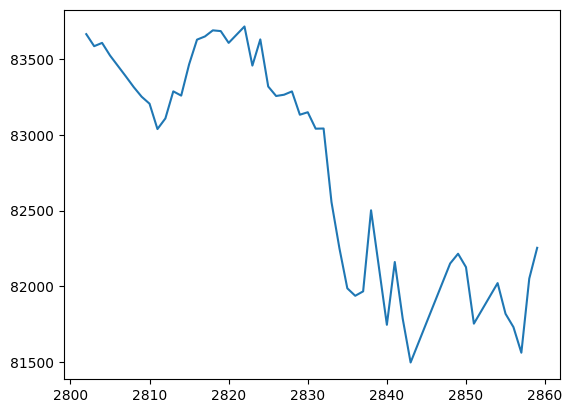

<Figure size 1000x400 with 0 Axes>

In [68]:
run_analysis(
    selected_timeframes=[{"interval": "15m", "period": "30d", "atr": 0.02}],
    plot_timeframes=["15m"],
    alert_timeframes=["15m"]
)


In [ ]:
df_log.head()




In [ ]:
limpar_prediction_log()


✅ Log limpo com sucesso. Entradas de 1970 removidas!


In [ ]:
df = pd.read_csv("prediction_log.csv")
for i in range(5):
    print(f"Tipo de Signal linha {i}: {type(df.iloc[i]['Signal'])}, valor: {df.iloc[i]['Signal']}")


In [ ]:
def limpar_prediction_log(path="prediction_log.csv"):
    if not os.path.exists(path):
        print("⚠️ Arquivo de log não encontrado.")
        return

    df = pd.read_csv(path)
    df = df.dropna(subset=["Date"])
    df["Date"] = pd.to_datetime(df["Date"], errors="coerce")
    df = df[df["Date"].dt.year >= 2000]
    df.to_csv(path, index=False)
    print("✅ Log limpo com sucesso. Entradas de 1970 removidas!")

limpar_prediction_log()



✅ Log limpo com sucesso. Entradas de 1970 removidas!


In [67]:
import os
if os.path.exists("/content/prediction_log.csv"):
    os.remove("/content/prediction_log.csv")
    print("🧹 prediction_log.csv deletado com sucesso.")

🧹 prediction_log.csv deletado com sucesso.


In [14]:
import os
os.remove("/content/prediction_log.csv")

In [48]:
def simular_todos_trades(path_log="prediction_log.csv"):
    if not os.path.exists(path_log):
        print("❌ Arquivo de log não encontrado.")
        return

    df_log = pd.read_csv(path_log)
    df_log["Date"] = pd.to_datetime(df_log["Date"], errors="coerce")
    df_log = df_log[df_log["Date"].dt.year >= 2000]
    df_log = df_log.dropna(subset=["Asset", "Timeframe", "Price", "TP1", "SL", "Signal"])

    # ✅ Ignora sinais neutros
    df_log = df_log[df_log["Signal"].isin([0, 1])]

    # 🔧 Garante que os valores sejam escalares
    df_log["Price"] = pd.to_numeric(df_log["Price"], errors="coerce")
    df_log["TP1"] = pd.to_numeric(df_log["TP1"].apply(lambda x: eval(x)[0] if isinstance(x, str) and x.startswith("[") else x), errors="coerce")
    df_log["SL"] = pd.to_numeric(df_log["SL"].apply(lambda x: eval(x)[0] if isinstance(x, str) and x.startswith("[") else x), errors="coerce")
    df_log["Signal"] = pd.to_numeric(df_log["Signal"].apply(lambda x: eval(x)[0] if isinstance(x, str) and x.startswith("[") else x), errors="coerce", downcast="integer")

    sim_results = []

    for idx, row in df_log.iterrows():
        try:
            res = simular_trade(row)
            if res:
                sim_results.append(res)
        except Exception as e:
            print(f"❌ Erro ao simular linha {idx}: {e}")

    if not sim_results:
        print("⚠️ Nenhuma simulação válida foi executada.")
        return

    df_trades = pd.DataFrame(sim_results)
    df_trades["Capital Atual"] = pd.to_numeric(df_trades["Capital Atual"], errors="coerce")
    df_trades.to_csv("trades_simulados.csv", index=False)
    print("✅ Simulação concluída. Resultados salvos em trades_simulados.csv")

    # ✅ Diagnóstico final
    print(f"📊 Total de trades simulados: {len(df_trades)}")
    try:
        capital_final = df_trades["Capital Atual"].iloc[-1]
        if isinstance(capital_final, pd.Series):
            capital_final = capital_final.squeeze()
        capital_final = float(capital_final)
        print(f"💰 Capital final: ${capital_final:,.2f}")
    except Exception as e:
        print(f"⚠️ Erro ao exibir capital final: {e}")
        print(f"🧪 Valor bruto: {df_trades['Capital Atual'].iloc[-1]}")

    return df_trades
